In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import IPython.display as ipd
import tensorflow_io as tfio
from pathlib import Path
import numpy as np
import random
from skimage.transform import rotate

classical_path = "/Users/johnwhendricks/Desktop/soundRecognition/Data/genres_original/classical"
rock_path = "/Users/johnwhendricks/Desktop/soundRecognition/Data/genres_original/rock"

In [3]:
classical_wav = [classical_path + '/' + p for p in os.listdir(classical_path)]
rock_wav = [rock_path + '/' + p for p in os.listdir(rock_path)]
num_classical = len(classical_wav)
num_rock = len(rock_wav)
print(f"Number of Classical Songs: {num_classical}")
print(f"Number of Rock Songs: {num_rock}")

Number of Classical Songs: 100
Number of Rock Songs: 100


In [4]:
def get_audio(path):
    
    audio_binary = tf.io.read_file(path)
    
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    
    waveform = tf.squeeze(audio, axis=-1)
    
    return waveform, sample_rate.numpy()

In [5]:
waveform, sample_rate = get_audio(classical_wav[0])
print(waveform)
print(sample_rate)

tf.Tensor(
[-0.01782227 -0.01669312 -0.01486206 ... -0.00531006 -0.00546265
 -0.00549316], shape=(661794,), dtype=float32)
22050


2022-10-01 12:54:15.649905: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
waveform, sample_rate = get_audio(classical_wav[1])
print(waveform)
print(sample_rate)

tf.Tensor(
[-0.06307983 -0.05401611 -0.04678345 ...  0.18322754  0.17730713
  0.16671753], shape=(665280,), dtype=float32)
22050


In [7]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [62]:
waveform, sample_rate = get_audio(rock_wav[1])
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [8]:
waveform.numpy()

array([-0.06307983, -0.05401611, -0.04678345, ...,  0.18322754,
        0.17730713,  0.16671753], dtype=float32)

In [9]:
def plot_audio(path):
    
    waveform, sample_rate = get_audio(path)
    
    plt.figure()
    
    plt.plot(waveform.numpy())
    
    return waveform, sample_rate

    
    
    

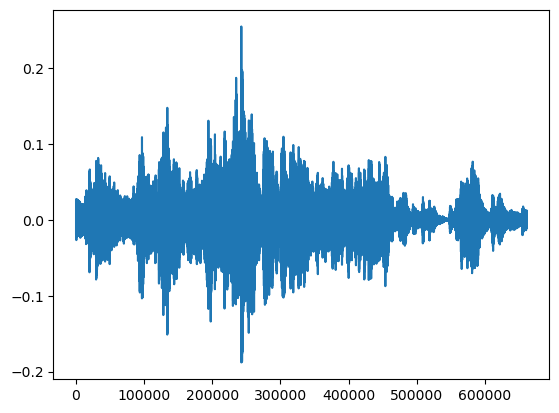

In [8]:
waveform, sample_rate = plot_audio(classical_wav[0])


In [10]:
def load_audio_files(path: str, label: str):
    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        utterance_number = speaker.split("_nohash_")
        utterance_number = int(i)+1
    
        # Load audio
        waveform, sample_rate = get_audio(file_path)
        dataset.append([waveform, sample_rate, label, utterance_number])
        
    return dataset

In [11]:
trainset_classical = load_audio_files("/Users/johnwhendricks/Desktop/soundRecognition/Data/genres_original/classical", 'classical')
trainset_rock = load_audio_files("/Users/johnwhendricks/Desktop/soundRecognition/Data/genres_original/rock", 'rock')
print(len(trainset_classical))
print(len(trainset_rock))

100
100


In [12]:
classical_waveform1 = trainset_classical[0][0]
print(classical_waveform1)

tf.Tensor(
[-0.02008057 -0.01748657  0.00418091 ...  0.01934814  0.027771
  0.03131104], shape=(661794,), dtype=float32)


In [13]:
tf.shape(classical_waveform1)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([661794], dtype=int32)>

In [14]:
lengths = [trainset_classical[i][0].shape[0] for i in range(100)]
max_len = max(lengths)

In [15]:
print(max_len)

672282


In [16]:
def get_spectrogram(waveform):
    frame_length = 255
    frame_step = 128
    
    zero_padding = tf.zeros([max_len] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length_waveform = tf.concat([waveform, zero_padding], 0)
    spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length,stride=frame_step)
    
    return spect

In [17]:
spect1 = get_spectrogram(classical_waveform1)

/var/folders/sx/dymxkj2j1636xvkc7jyhyp840000gn/T/ipykernel_39038/3246488045.py:3: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


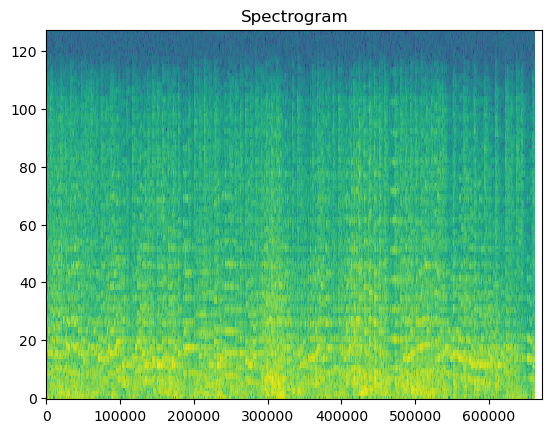

In [18]:
def plot_spectrogram(spectrogram, ax, title):
    
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y= range(height)
    ax.pcolormesh(X,Y, log_spec)
    ax.set_xlim([0, max_len])
    ax.set_title(title)
    
fig, ax = plt.subplots()
plot_spectrogram(spect1.numpy(), ax, 'Spectrogram')
plt.show()

/var/folders/sx/dymxkj2j1636xvkc7jyhyp840000gn/T/ipykernel_39038/3246488045.py:3: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


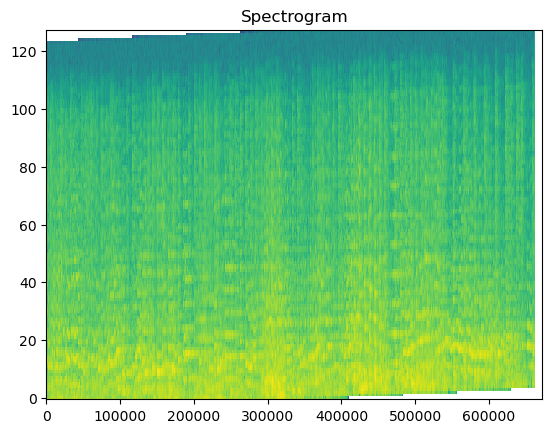

In [22]:
fig, ax = plt.subplots()
plot_spectrogram(rotate(spect1.numpy(),0.1), ax, 'Spectrogram')
plt.show()

In [52]:
def create_images(dataset, label_dir):
    test_directory = f'/Users/johnwhendricks/Desktop/soundRecognition/Data/test/{label_dir}'
    train_directory = f'/Users/johnwhendricks/Desktop/soundRecognition/Data/train/{label_dir}'
    
    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)

    for i, data in enumerate(dataset):
        
        waveform = data[0]
        spectrogram = get_spectrogram(waveform)
        
        if i % 10 == 0:
            spectrogram_rot = rotate(spectrogram.numpy(), random.random())
        
            plt.imsave(f'/Users/johnwhendricks/Desktop/soundRecognition/Data/test/{label_dir}/spec_img{i}_rot.png',
                      spectrogram_rot,cmap='gray')
        
        random_int = random.randint(0,1)
        
        if random_int == 0:
            plt.imsave(f'/Users/johnwhendricks/Desktop/soundRecognition/Data/test/{label_dir}/spec_img{i}.png',
                      spectrogram.numpy(),cmap='gray')
        else:
            plt.imsave(f'/Users/johnwhendricks/Desktop/soundRecognition/Data/train/{label_dir}/spec_img{i}.png',
                      spectrogram.numpy(), cmap='gray')

In [53]:
create_images(trainset_classical,'classical')
create_images(trainset_rock, 'rock')

In [54]:
train_directory = '/Users/johnwhendricks/Desktop/soundRecognition/Data/train/'
test_directory = '/Users/johnwhendricks/Desktop/soundRecognition/Data/test/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256,256), 
    validation_split = 0.1, seed=42, subset='validation')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256,256),
    validation_split = None, subset=None)

Found 177 files belonging to 2 classes.
Using 17 files for validation.
Found 185 files belonging to 2 classes.


In [55]:
class_names = train_ds.class_names
print(class_names)

['classical', 'rock']


In [56]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential

model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
#     tf.keras.layers.experimental.preprocessing.RandomFlip(),
    Conv2D(16, 3, padding='same', activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [57]:
learning_rate = 0.125

loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics=['accuracy']
model.compile(optimizer, loss_fn, metrics)

In [58]:
# es = tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=7, verbose = 2)

In [59]:
epochs = 30

history = model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.6958 - accuracy: 0.1765 - val_loss: 0.9123 - val_accuracy: 0.4973
Epoch 2/30
1/1 [==============================] - 1s 1s/step - loss: 0.5394 - accuracy: 0.7059 - val_loss: 0.6874 - val_accuracy: 0.5243
Epoch 3/30
1/1 [==============================] - 1s 1s/step - loss: 0.6662 - accuracy: 0.9412 - val_loss: 0.6808 - val_accuracy: 0.4973
Epoch 4/30
1/1 [==============================] - 1s 1s/step - loss: 0.6087 - accuracy: 0.7059 - val_loss: 1.7387 - val_accuracy: 0.4973
Epoch 5/30
1/1 [==============================] - 1s 1s/step - loss: 0.9632 - accuracy: 0.7059 - val_loss: 0.6677 - val_accuracy: 0.5514
Epoch 6/30
1/1 [==============================] - 1s 1s/step - loss: 0.5827 - accuracy: 1.0000 - val_loss: 0.6472 - val_accuracy: 0.5297
Epoch 7/30
1/1 [==============================] - 1s 1s/step - loss: 0.3776 - accuracy: 0.8235 - val_loss: 1.5731 - val_accuracy: 0.4973
Epoch 8/30
1/1 [=========================

In [33]:
base_model = tf.keras.applications.ResNet50V2(include_top= False, weights = 'imagenet', input_shape = (256, 256, 3))

base_model.trainable = False

x = base_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1000)(x)

x = tf.keras.layers.Dropout(0.1)(x)

output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs = base_model.input, outputs = output)

In [34]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9), loss = "binary_crossentropy", metrics = ['accuracy'])

In [35]:
history2 = model.fit(train_ds, epochs = 20, validation_data=test_ds)

Epoch 1/10
1/1 [==============================] - 13s 13s/step - loss: 17.1981 - accuracy: 0.2667 - val_loss: 10.1424 - val_accuracy: 0.5061
Epoch 2/10
1/1 [==============================] - 10s 10s/step - loss: 15.8301 - accuracy: 0.2667 - val_loss: 9.9206 - val_accuracy: 0.5061
Epoch 3/10
1/1 [==============================] - 10s 10s/step - loss: 13.9330 - accuracy: 0.2667 - val_loss: 9.6044 - val_accuracy: 0.5061
Epoch 4/10
1/1 [==============================] - 10s 10s/step - loss: 13.4744 - accuracy: 0.2667 - val_loss: 9.2030 - val_accuracy: 0.5061
Epoch 5/10
1/1 [==============================] - 10s 10s/step - loss: 12.8846 - accuracy: 0.2000 - val_loss: 8.7271 - val_accuracy: 0.5061
Epoch 6/10
1/1 [==============================] - 11s 11s/step - loss: 13.1153 - accuracy: 0.2667 - val_loss: 8.1846 - val_accuracy: 0.4939
Epoch 7/10
1/1 [==============================] - 11s 11s/step - loss: 11.4165 - accuracy: 0.2667 - val_loss: 7.5825 - val_accuracy: 0.4939
Epoch 8/10
1/1 [===

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

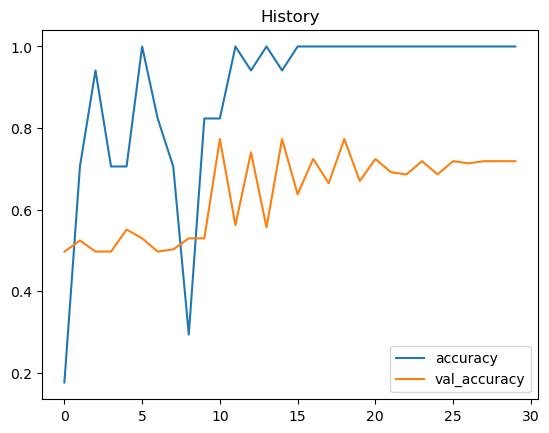

In [61]:
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.legend()
plt.title("History")
plt.show()

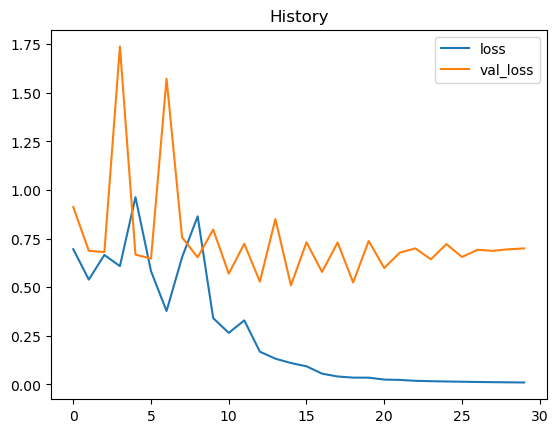

In [63]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.title("History")
plt.show()